In [3]:
import os
from PIL import Image
import glob
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import *
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing.image import *
from matplotlib import pyplot as plt


<h5> Photos are uploaded from a folder which contains all the Aligned and Cropped images of the UTKFace Dataset. 
    <br>
    </h5> 
    <p>Link of the dataset: <a href =  https://susanqq.github.io/UTKFace/> 
     https://susanqq.github.io/UTK
<a/>
</p>
<p> Age is extracted from the filename of the image. </p>



In [4]:
image_list = []
img_age = []

for filename in glob.glob('UTKFace/*.jpg'):  
    filename = str(filename)
    img_age.append(filename[filename.find("\\")+1:filename.find("_")])
    im=cv2.imread(filename)
    im = cv2.resize(im, (50,50))
    image_list.append(np.asarray(im))


data = np.array(image_list)
labels = np.array(img_age).astype(np.float)


<h5> It can be seen that data is not equally distributed, Nearly 10% of the data comes from 26 year olds. </h5>

In [5]:
df = pd.DataFrame(labels, columns = ["Age"])

df["Age"].value_counts().head(10)

26.0    2197
1.0     1123
28.0     918
35.0     880
24.0     859
25.0     734
30.0     724
32.0     664
27.0     615
29.0     570
Name: Age, dtype: int64

<h5> Visualizing the distribution of data: </h5>

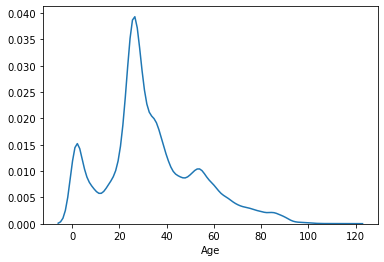

In [6]:
sns.distplot(df["Age"], hist = False)

<h5>To better understand the distribution, we make a quantile based binning of the ages.</h5>

In [7]:
df["bins"] = pd.qcut(df["Age"], 10)

df.groupby("bins").count()

,Age
bins,
"(0.999, 6.0]",2494
"(6.0, 20.0]",2383
"(20.0, 25.0]",2760
"(25.0, 26.0]",2197
"(26.0, 29.0]",2103
"(29.0, 34.0]",2290
"(34.0, 40.0]",2773
"(40.0, 50.0]",2100
"(50.0, 61.0]",2372


<h5>Binning the data into age groups. 
<br>
<br>    
I did this binning considering the distribution of the data, but I also wanted every class to be similar and logical in itself.

</h5>

In [8]:
i = 0

while i < len(labels):
    if labels[i] >= 0 and labels[i] < 4:
        labels[i] = 0
    elif labels[i] >= 4 and labels[i] < 13:
        labels[i] = 1
    elif labels[i] >= 13 and labels[i] < 21:
        labels[i] = 2
    elif labels[i] >= 21 and labels[i] < 31:
        labels[i] = 3
    elif labels[i] >= 31 and labels[i] < 46:
        labels[i] = 4
    elif labels[i] >= 46 and labels[i] < 65:
        labels[i] = 5
    elif labels[i] >= 65:
        labels[i] = 6
    i += 1
    
age_dict = {
    0:"0-3",
    1:"4-12",
    2:"13-20",
    3:"21-30",
    4:"31-45",
    5:"46-64",
    6:"65+",

}

<h5>Size of the classes: </h5>

In [9]:
pd.Series(labels).value_counts().sort_index()

0.0    1894
1.0    1519
2.0    1464
3.0    7784
4.0    5434
5.0    3655
6.0    1958
dtype: int64

<h5>Splitting the data: </h5>

In [10]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size = 0.2)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5)

In [11]:
print(X_train.shape)

(18966, 50, 50, 3)


<h5>There aren't too many images, so I used the Data Generator class of Keras for Data Augmentation.
<br>
    <br>
I only inserted newly created images to training set, not to the validation or test sets.</h5>

In [12]:
datagen = ImageDataGenerator()

datagen.fit(X_train)
X_batch = datagen.flow(X_train, y_train, batch_size=32)

X_aug = []
y_aug = []

for i in range(0,len(X_batch)):
    batch = X_batch[i]
    for elem in batch[:][0]:
        X_aug.append(elem)
    for elem in batch[:][1]:
        y_aug.append(elem)
        
X_aug = np.array(X_aug)        
y_aug = np.array(y_aug)

X_train = np.append(X_train, X_aug, axis = 0)
y_train = np.append(y_train, y_aug, axis = 0)

In [13]:
X_train.shape

(37932, 50, 50, 3)

In [14]:
train_size = X_train.shape[0]

val_size = X_val.shape[0]

In [15]:
train = tf.data.Dataset.from_tensor_slices((X_train, to_categorical(y_train)))
train = train.shuffle(train_size).batch(32)

val = tf.data.Dataset.from_tensor_slices((X_val, to_categorical(y_val)))
val = val.shuffle(val_size).batch(32)

In [16]:
del X_train
del X_val
del y_train
del y_val

del X_aug
del y_aug

<h5>Model</h5>

In [20]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters = 128, kernel_size = 3),  
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(filters = 64, kernel_size = 3),    
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(filters = 64, kernel_size = 3),    
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Dense(32, activation = "relu"),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(7, activation = "sigmoid")
])

In [21]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose = 1,
    save_best_only=True)

In [22]:
opt = Adam()

model.compile(
  opt,
  loss='categorical_crossentropy',
  metrics=["accuracy"])


model.fit(
 train,
  epochs=15,
  validation_data=val,
   callbacks=[model_checkpoint_callback]
)

Train for 1186 steps, validate for 75 steps
Epoch 1/15
1183/1186 [============================>.] - ETA: 0s - loss: 1.2100 - accuracy: 0.5040
Epoch 00001: val_accuracy improved from -inf to 0.30747, saving model to checkpoint.hdf5
1186/1186 [==============================] - 59s 49ms/step - loss: 1.2095 - accuracy: 0.5041 - val_loss: 1.9166 - val_accuracy: 0.3075
Epoch 2/15
1184/1186 [============================>.] - ETA: 0s - loss: 0.9689 - accuracy: 0.5958 - ETA: 30s - loss: 0.9961 - accu - ETA: 29s - loss: 0.9961 - accuracy - ETA:
Epoch 00002: val_accuracy improved from 0.30747 to 0.36482, saving model to checkpoint.hdf5
1186/1186 [==============================] - 35s 30ms/step - loss: 0.9685 - accuracy: 0.5959 - val_loss: 1.7231 - val_accuracy: 0.3648
Epoch 3/15
1184/1186 [============================>.] - ETA: 0s - loss: 0.8810 - accuracy: 0.6305 - ETA: 46s - loss: 0.8693 - accurac - ETA:  - ETA: 39s - loss: 0.8938 - ac - ETA: 1s
Epoch 00003: val_accuracy improved from 0.36482 t

In [23]:
model.load_weights("checkpoint.hdf5")

<h5>Total accuracy and Classwise Accuracy Scores </h5>

In [24]:
model_pred = model.predict(X_test)
score = np.max(model_pred, axis = 1)
pred = np.argmax(model_pred, axis = 1)


df = pd.DataFrame(columns = ["Actual","Pred","Score"])


df["Actual"] = y_test.astype("int")
df["Pred"] = pred
df["Score"] = score


Accuracy = (len(df.query("Actual == Pred"))/len(df))*100

print("Accuracy of the model: ", Accuracy)

class_accuracy = {}

for elem in set(df["Actual"]):  
    class_accuracy[age_dict[elem]] = (len(df.loc[(df["Actual"] == elem) & (df["Pred"] == elem)])/len(df.loc[df["Actual"] == elem]))*100
    print("Accuracy of Class", age_dict[elem], ":",class_accuracy[age_dict[elem]])
  

Accuracy of the model:  61.07127794179671
Accuracy of Class 0-3 : 83.25358851674642
Accuracy of Class 4-12 : 58.857142857142854
Accuracy of Class 13-20 : 22.058823529411764
Accuracy of Class 21-30 : 76.90355329949239
Accuracy of Class 31-45 : 42.96724470134875
Accuracy of Class 46-64 : 61.725067385444746
Accuracy of Class 65+ : 47.97687861271676


<h5>Model is successful when it comes to predicting age group 0-3, but it is not as accurate when it comes down to middle age, especially for the second class, which consists of ages 13-20, so I wanted to see what are the predictions of the model for Class 2.
</h5>

In [25]:
df.loc[df["Actual"] == 2].groupby(["Actual","Pred"]).count().rename(columns = {"Score":"Count"})

Count
Actual Pred       
2      1        19
       2        30
       3        80
       4         6
       5         1

<h5> Plotting Actual values and model predictions for all the classes. I think it is normal that most mistakes are made with the neighboring classes, for example model has confused 65+ ages mostly with 46-64. 
    <br>
    <br>
    Thinking from a human perspective, this is pretty normal, since a human is also most likely to make a wrong prediction of a class with its neighboring one.
    <h5>

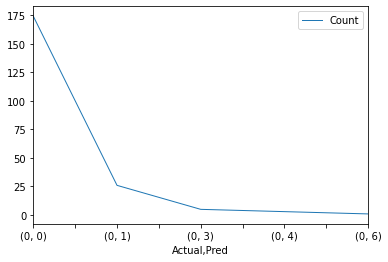

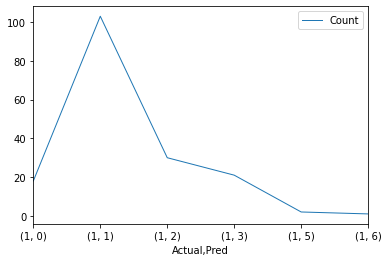

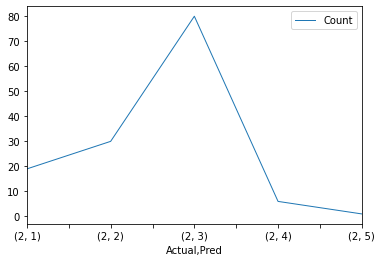

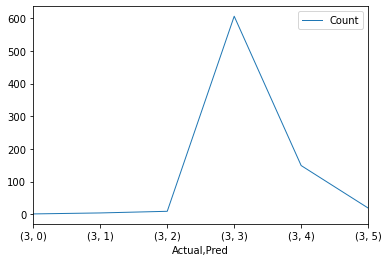

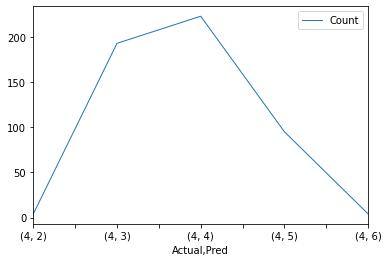

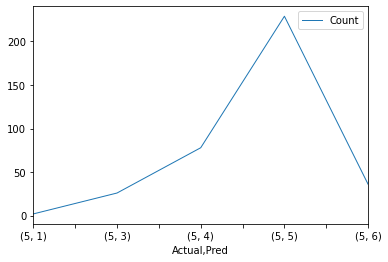

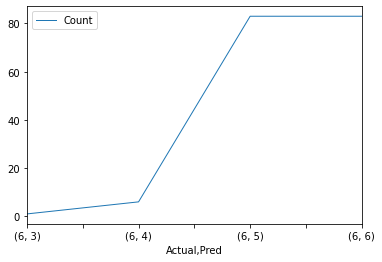

In [26]:
for age_group in set(df["Actual"]):
    df.loc[df["Actual"] == age_group].groupby(["Actual","Pred"]).count().rename(columns = {"Score":"Count"}).plot(linewidth = 1)
     

<h5>100 images which the model has falsely predicted: </h5>

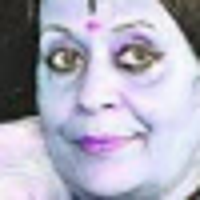

Actual: 65+ 
Pred: 46-64
Score: 0.018904531


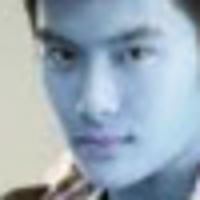

Actual: 21-30 
Pred: 13-20
Score: 0.09984207


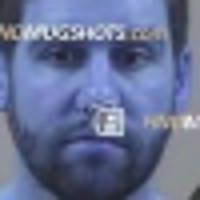

Actual: 21-30 
Pred: 31-45
Score: 0.031934578


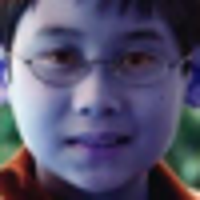

Actual: 4-12 
Pred: 13-20
Score: 0.013989807


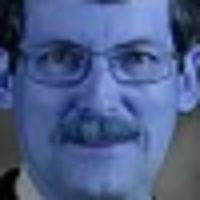

Actual: 46-64 
Pred: 65+
Score: 0.058617245


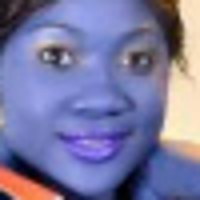

Actual: 31-45 
Pred: 21-30
Score: 0.28155524


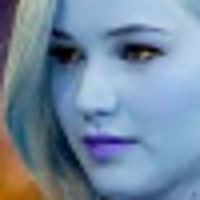

Actual: 13-20 
Pred: 21-30
Score: 0.1148841


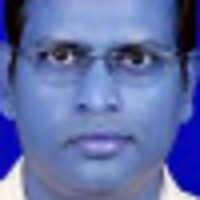

Actual: 21-30 
Pred: 31-45
Score: 0.08334628


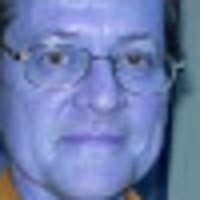

Actual: 65+ 
Pred: 46-64
Score: 0.2274894


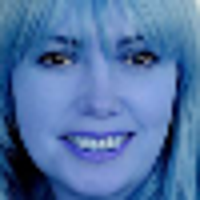

Actual: 46-64 
Pred: 21-30
Score: 0.00016601771


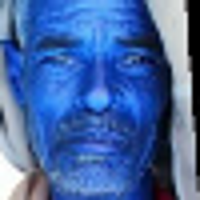

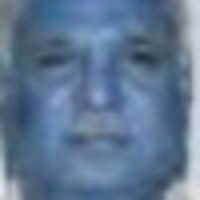

Actual: 65+ 
Pred: 46-64
Score: 0.015833795
Actual: 65+ 
Pred: 46-64
Score: 0.17804988


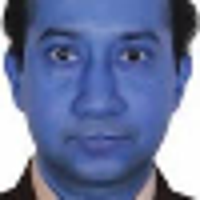

Actual: 31-45 
Pred: 46-64
Score: 0.010525906


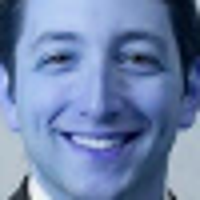

Actual: 21-30 
Pred: 31-45
Score: 0.008119066


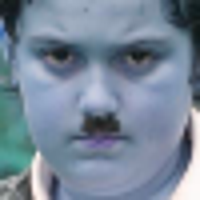

Actual: 4-12 
Pred: 21-30
Score: 0.0058189416


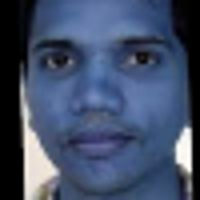

Actual: 31-45 
Pred: 21-30
Score: 0.006743689


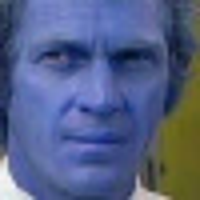

Actual: 31-45 
Pred: 46-64
Score: 0.058390103


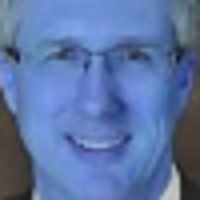

Actual: 31-45 
Pred: 46-64
Score: 0.045998067


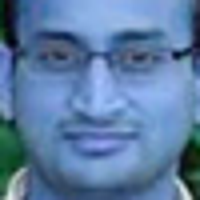

Actual: 21-30 
Pred: 31-45
Score: 0.21037513


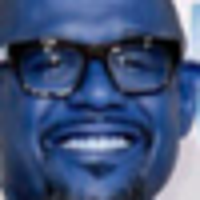

Actual: 46-64 
Pred: 31-45
Score: 0.027411401


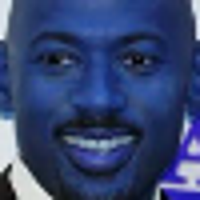

Actual: 31-45 
Pred: 21-30
Score: 0.0034356914


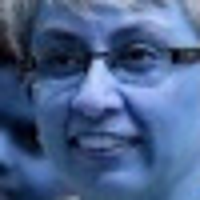

Actual: 46-64 
Pred: 31-45
Score: 0.018513788


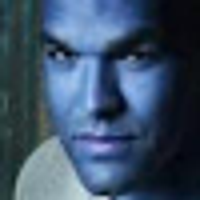

Actual: 21-30 
Pred: 31-45
Score: 0.09334742


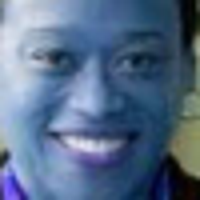

Actual: 31-45 
Pred: 21-30
Score: 0.1194305


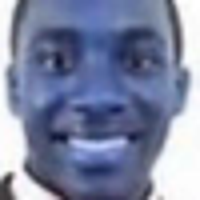

Actual: 31-45 
Pred: 21-30
Score: 0.03721646


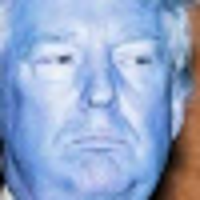

Actual: 65+ 
Pred: 46-64
Score: 0.006818185


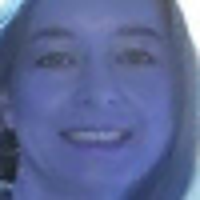

Actual: 31-45 
Pred: 46-64
Score: 0.0012310927


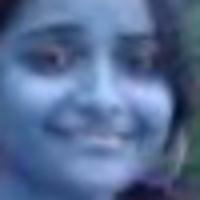

Actual: 21-30 
Pred: 31-45
Score: 0.010008841


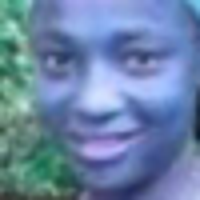

Actual: 31-45 
Pred: 21-30
Score: 0.0078907795


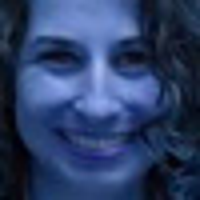

Actual: 31-45 
Pred: 21-30
Score: 0.12626657


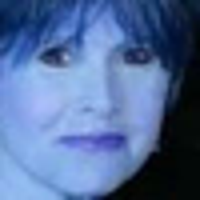

Actual: 46-64 
Pred: 21-30
Score: 0.0014549459


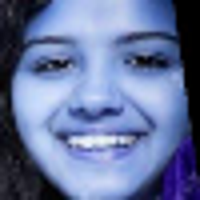

Actual: 13-20 
Pred: 21-30
Score: 0.036399707


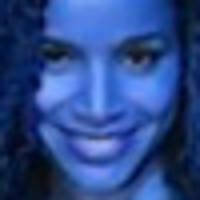

Actual: 46-64 
Pred: 21-30
Score: 0.36823773


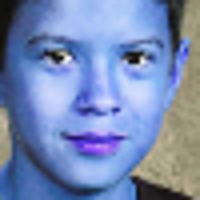

Actual: 13-20 
Pred: 4-12
Score: 0.0006580612


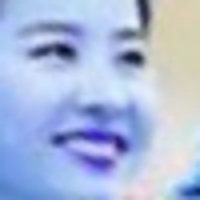

Actual: 21-30 
Pred: 31-45
Score: 0.20864849


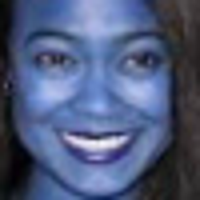

Actual: 31-45 
Pred: 21-30
Score: 0.14973792


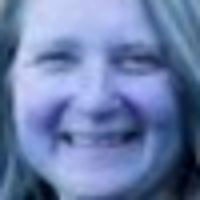

Actual: 31-45 
Pred: 46-64
Score: 0.010934336


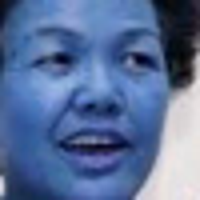

Actual: 46-64 
Pred: 31-45
Score: 0.0004492298


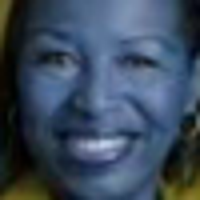

Actual: 46-64 
Pred: 31-45
Score: 0.05844756


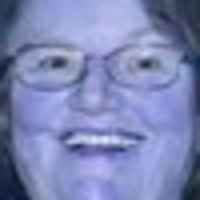

Actual: 46-64 
Pred: 21-30
Score: 0.00016330143


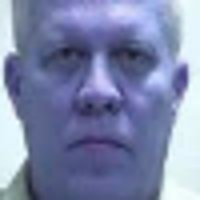

Actual: 31-45 
Pred: 65+
Score: 0.026119024


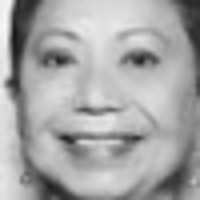

Actual: 46-64 
Pred: 31-45
Score: 0.035838433


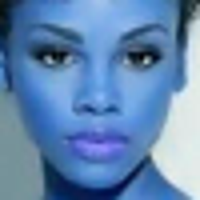

Actual: 13-20 
Pred: 21-30
Score: 0.14929745


In [27]:
i = 0
wrong_indexes = df.query("Actual != Pred").index.values

while i < 100:
    if i in wrong_indexes:
        display(Image.fromarray(X_test[i],"RGB").resize((200,200)))
        print("Actual:",age_dict[y_test[i]],"\nPred:", age_dict[pred[i]])
        print("Score:", score[i])
    i += 1

<h5> A function to predict an image outside of the dataset. </h5>

In [28]:
def predict(inp):
    if str(type(inp)) == "<class 'PIL.JpegImagePlugin.JpegImageFile'>":
        score = np.max((model.predict(np.expand_dims(np.array(inp.resize((50,50))), axis = 0))*100).round())
        group = np.argmax(model.predict(np.expand_dims(np.array(inp.resize((50,50))), axis = 0)))
        display(inp.resize((250,250)))
        print("Possible Age Group:",age_dict[group])
        print("Score:",score)
    elif str(type(inp)) ==  "<class 'list'>":  
        for elem in inp:
            score = np.max((model.predict(np.expand_dims(np.array(elem.resize((50,50))), axis = 0))*100).round())
            group = np.argmax(model.predict(np.expand_dims(np.array(elem.resize((50,50))), axis = 0)))
            display(inp.resize((250,250)))
            print("Tahmini Yaş Grubu:",age_dict[group],"\n")
            print("Score:",score)          
    else:
        print("Wrong Data Type!")